In [1]:
#import pandas as pd

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from collections import Counter

In [3]:
# Define data types for memory optimization
dtype_events = {
    'event_timestamp': 'str',
    'region': 'category',
    'ua_device_type': 'category',
    'ua_client_type': 'category',
    'ua_os': 'category',
    'ua_client_name': 'category',
    'total_watchtime': 'int32',
    'rutube_video_id': 'category',
    'viewer_uid': 'int32'
}

dtype_video_info = {
    'rutube_video_id': 'category',
    'title': 'object',
    'category': 'category',
    'duration': 'int32',
    'author_id': 'int32'
}

dtype_targets = {
    'viewer_uid': 'int32',
    'gender': 'category',
    'age': 'int8'
}

# Load train_events.csv
train_events = pd.read_csv('/kaggle/input/dadadadadadadadadadadaddadadadadadadadadadadada/train_events.csv', dtype=dtype_events, parse_dates=['event_timestamp'])
print(f"Train Events Shape: {train_events.shape}")

all_events = pd.read_csv('/kaggle/input/dadadadadadadadadadadaddadadadadadadadadadadada/all_events.csv', dtype=dtype_events, parse_dates=['event_timestamp'])
print(f"All Events Shape: {all_events.shape}")

# Load video_info.csv
video_info = pd.read_csv('/kaggle/input/dadadadadadadadadadadaddadadadadadadadadadadada/video_info_v2.csv', dtype=dtype_video_info)
print(f"Video Info Shape: {video_info.shape}")

# Load train_targets.csv
train_targets = pd.read_csv('/kaggle/input/dadadadadadadadadadadaddadadadadadadadadadadada/train_targets.csv', dtype=dtype_targets)
print(f"Train Targets Shape: {train_targets.shape}")

Train Events Shape: (1759616, 9)
All Events Shape: (8439624, 9)
Video Info Shape: (481480, 5)
Train Targets Shape: (180012, 4)


In [4]:
all_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8439624 entries, 0 to 8439623
Data columns (total 9 columns):
 #   Column           Dtype   
---  ------           -----   
 0   event_timestamp  object  
 1   region           category
 2   ua_device_type   category
 3   ua_client_type   category
 4   ua_os            category
 5   ua_client_name   category
 6   total_watchtime  int32   
 7   rutube_video_id  category
 8   viewer_uid       int32   
dtypes: category(6), int32(2), object(1)
memory usage: 211.8+ MB


## 1. Преобразование времени в местное время и вычисление сдвига

In [5]:
# Преобразование столбца event_timestamp в тип datetime, если это еще не сделано
all_events['event_timestamp'] = pd.to_datetime(all_events['event_timestamp'])
train_events['event_timestamp'] = pd.to_datetime(train_events['event_timestamp'])
# Словарь для соответствия регионов и часовых поясов
# Словарь для соответствия регионов и смещения времени относительно Москвы
timezone_mapping = {
    'Tatarstan Republic': 0,
    'Bashkortostan Republic': 0,
    'Novosibirsk Oblast': 4,
    'Moscow': 0,
    'Moscow Oblast': 0,
    'Omsk Oblast': 3,
    'Chuvashia': 0,
    'Krasnoyarsk Krai': 4,
    'Chelyabinsk': 2,
    'Kamchatka': 9,
    'Nizhny Novgorod Oblast': 0,
    'Krasnodar Krai': 0,
    'Volgograd Oblast': 0,
    'Kaliningrad Oblast': -1,
    'Kuzbass': 4,
    'Stavropol Kray': 0,
    'Samara Oblast': 1,
    'Amur Oblast': 6,
    'Sverdlovsk Oblast': 2,
    'St.-Petersburg': 0,
    'Yamalo-Nenets': 2,
    'Orenburg Oblast': 2,
    'Khanty-Mansia': 2,
    'Kaluga Oblast': 0,
    'Tomsk Oblast': 4,
    'Novgorod Oblast': 0,
    'Arkhangelskaya': 0,
    'North Ossetia–Alania': 0,
    'Kursk Oblast': 0,
    "Leningradskaya Oblast'": 0,
    'Krasnoyarskiy': 4,
    'Ivanovo Oblast': 0,
    'Altay Kray': 4,
    'Kurgan Oblast': 2,
    'Kostroma Oblast': 0,
    'Bryansk Oblast': 0,
    'Dagestan': 0,
    'Lipetsk Oblast': 0,
    'Vladimir Oblast': 0,
    'Kirov Oblast': 0,
    'Khabarovsk': 7,
    'Tambov Oblast': 0,
    'Chukotka': 9,
    'Voronezh Oblast': 0,
    'Sverdlovsk': 2,
    'Tula Oblast': 0,
    'Krasnodarskiy': 0,
    'Irkutsk Oblast': 5,
    'Saratov Oblast': 0,
    'Khakasiya Republic': 4,
    'Penza': 0,
    'Perm Krai': 2,
    'Oryol oblast': 0,
    'Vladimir': 0,
    'Smolensk Oblast': 0,
    'Penza Oblast': 0,
    'Mordoviya Republic': 0,
    'Tyumen’ Oblast': 2,
    'Sakha': 6,
    'Primorye': 7,
    'Zabaykalskiy (Transbaikal) Kray': 6,
    'Vologda Oblast': 0,
    'Yaroslavl Oblast': 0,
    'Crimea': 0,
    'Rostov': 0,
    'Ryazan Oblast': 0,
    'Perm': 2,
    'Chechnya': 0,
    'Udmurtiya Republic': 0,
    'Tver Oblast': 0,
    'Buryatiya Republic': 5,
    'Belgorod Oblast': 0,
    'Kaluga': 0,
    'Astrakhan Oblast': 0,
    'Karelia': 0,
    'Murmansk': 0,
    'Adygeya Republic': 0,
    'Kemerovo Oblast': 4,
    'Mariy-El Republic': 0,
    'Kursk': 0,
    'Saratovskaya Oblast': 0,
    'Sakhalin Oblast': 7,
    'Ivanovo': 0,
    'Tyumen Oblast': 2,
    'Stavropol’ Kray': 0,
    'Voronezj': 0,
    'Karachayevo-Cherkesiya Republic': 0,
    'Kabardino-Balkariya Republic': 0,
    'Ulyanovsk': 0,
    'North Ossetia': 0,
    'Komi': 0,
    'Smolensk': 0,
    'Tver’ Oblast': 0,
    'Sebastopol City': 0,
    'Pskov Oblast': 0,
    'Tula': 0,
    'Orel Oblast': 0,
    'Jaroslavl': 0,
    'Tambov': 0,
    'Kalmykiya Republic': 0,
    'Primorskiy (Maritime) Kray': 7,
    'Altai': 4,
    'Magadan Oblast': 8,
    'Vologda': 0,
    'Tyva Republic': 4,
    'Nenets': 0,
    'Smolenskaya Oblast’': 0,
    'Jewish Autonomous Oblast': 7,
    'Astrakhan': 0,
    'Ingushetiya Republic': 0,
    'Kirov': 0,
    'Transbaikal Territory': 6,
    'Omsk': 3,
    'Kaliningrad': -1,
    'Stavropol Krai': 0,
    'Arkhangelsk Oblast': 0
}

# Функция для преобразования времени в местное время и вычисления сдвига
def convert_to_local_time(row):
    region = row['region']
    time_shift = timezone_mapping.get(region, 0)
    local_time = row['event_timestamp'] + pd.Timedelta(hours=time_shift)
    return local_time, time_shift



all_events[['local_event_timestamp', 'time_shift']] = all_events.apply(lambda row: pd.Series(convert_to_local_time(row)), axis=1)
train_events[['local_event_timestamp', 'time_shift']] = train_events.apply(lambda row: pd.Series(convert_to_local_time(row)), axis=1)



In [ ]:
all_events

In [5]:
all_events = all_events.drop(columns=['event_timestamp'])
train_events = train_events.drop(columns=['event_timestamp'])

In [6]:
# Проверка результата
all_events.head()

,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid
0,Tatarstan Republic,smartphone,browser,Android,Chrome Mobile,60,video_395879,10813370
1,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,60,video_216518,10512324
2,Novosibirsk Oblast,smartphone,mobile app,Android,Rutube,121,video_41225,10951137
3,Moscow,desktop,browser,Windows,Yandex Browser,2324,video_215886,10912434
4,Moscow Oblast,smartphone,mobile app,Android,Rutube,6830,video_43631,10223585


## 2. Анализ распределения признаков в all_events

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


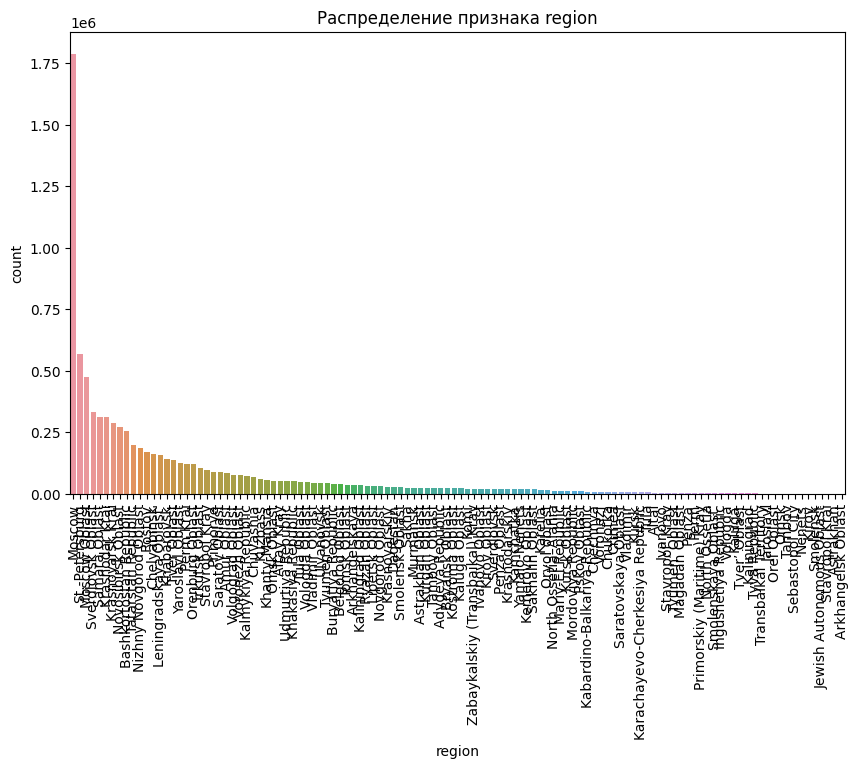

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


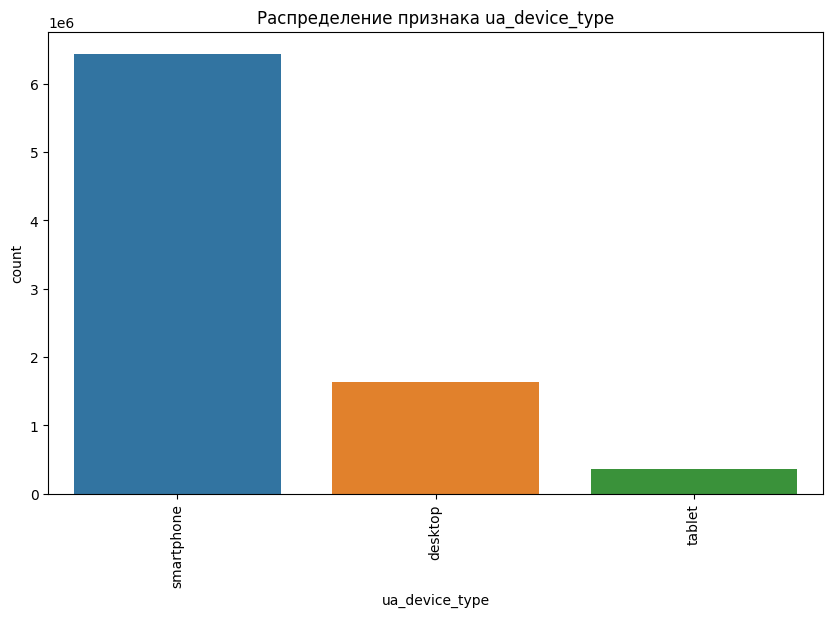

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


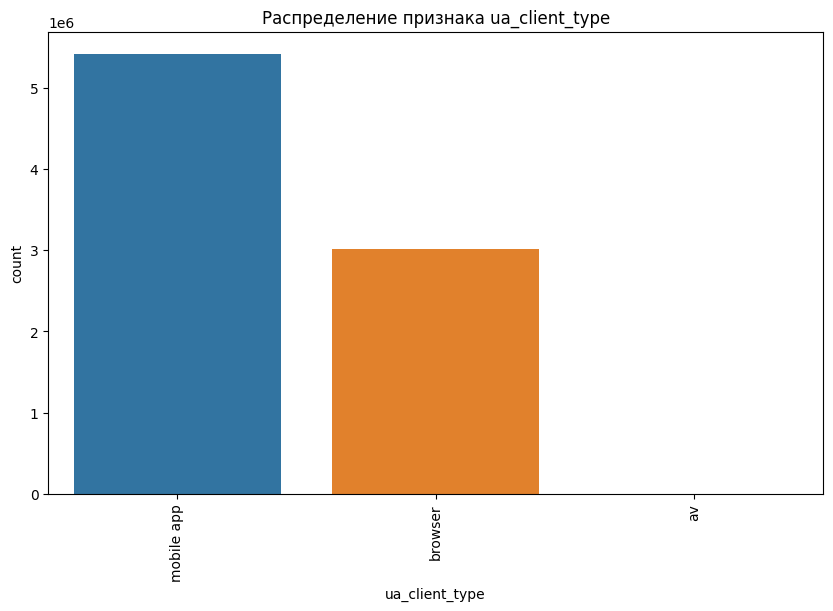

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


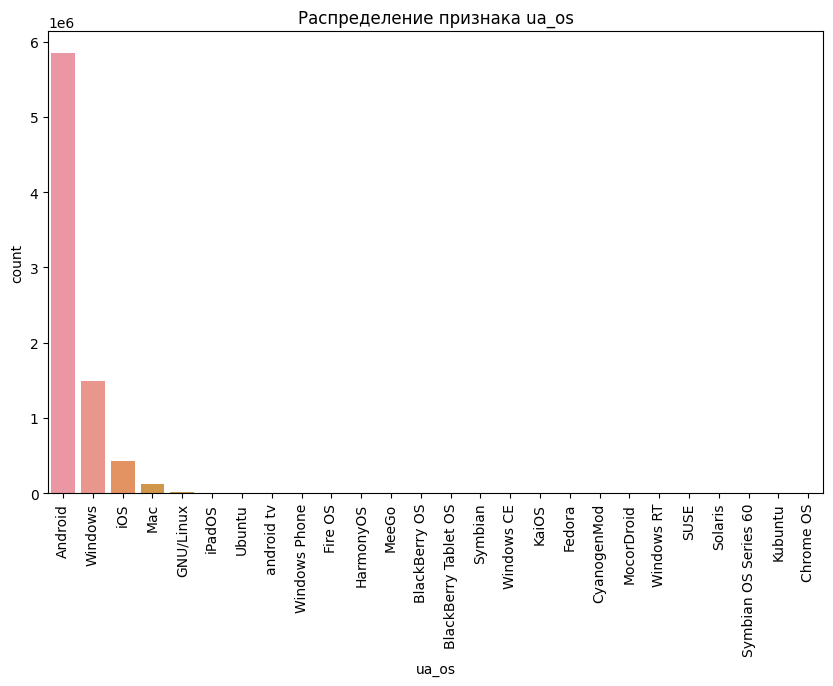

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


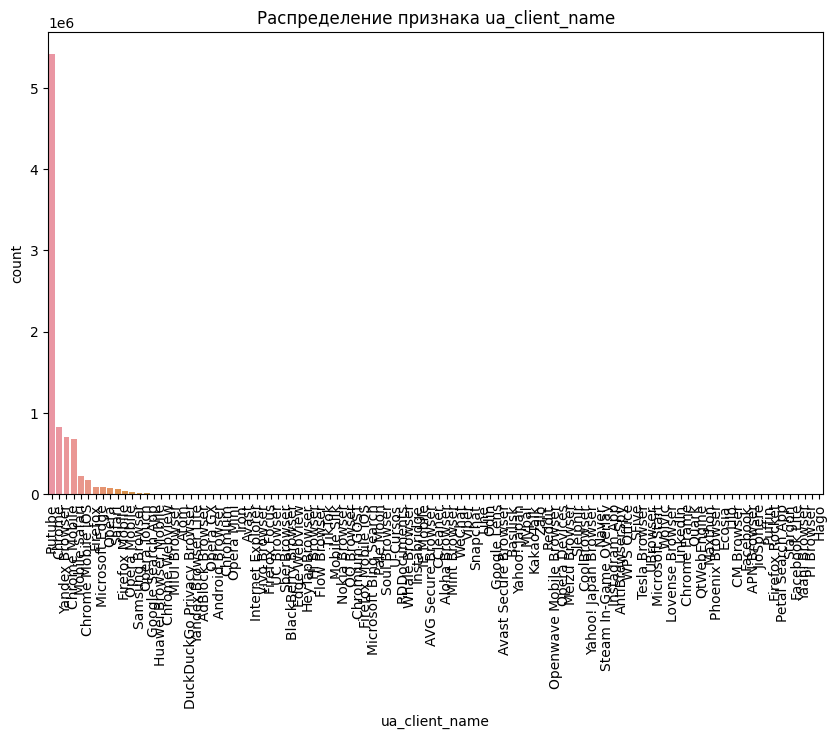

In [9]:
# Список категориальных признаков
categorical_features = ['region', 'ua_device_type', 'ua_client_type', 'ua_os', 'ua_client_name']

# Создание графиков для каждого категориального признака
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=all_events, x=feature, order=all_events[feature].value_counts().index)
    plt.title(f'Распределение признака {feature}')
    plt.xticks(rotation=90)
    plt.show()

## 3. Замена редко встречаемых признаков на Other или укрупнение категорий

Проверка на пропуски

In [7]:
# Проверка на пропуски

all_events.isnull().sum()

region                  0
ua_device_type          0
ua_client_type         13
ua_os              519630
ua_client_name         13
total_watchtime         0
rutube_video_id         0
viewer_uid              0
dtype: int64

In [8]:
train_events.isnull().sum()

region                  0
ua_device_type          0
ua_client_type          0
ua_os              117671
ua_client_name          0
total_watchtime         0
rutube_video_id         0
viewer_uid              0
dtype: int64

In [9]:
features = ['ua_client_type','ua_os','ua_client_name']

for f in features:
    # Найти наиболее распространенную категорию в колонке 'ua_client_name'
    most_common_category = all_events[f].mode()[0]
    print(f'Наиболее распространенная категория: {most_common_category}')

    # Заменить пустые значения на наиболее распространенную категорию
    all_events[f].fillna(most_common_category, inplace=True)

    # Заменить пустые значения на наиболее распространенную категорию
    train_events[f].fillna(most_common_category, inplace=True)    
# Проверка результатов
print(all_events.isnull().sum())
print(train_events.isnull().sum())


Наиболее распространенная категория: mobile app
Наиболее распространенная категория: Android
Наиболее распространенная категория: Rutube
region             0
ua_device_type     0
ua_client_type     0
ua_os              0
ua_client_name     0
total_watchtime    0
rutube_video_id    0
viewer_uid         0
dtype: int64


/tmp/ipykernel_30/2852257786.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_events[f].fillna(most_common_category, inplace=True)
/tmp/ipykernel_30/2852257786.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

region             0
ua_device_type     0
ua_client_type     0
ua_os              0
ua_client_name     0
total_watchtime    0
rutube_video_id    0
viewer_uid         0
dtype: int64


In [10]:
all_events['ua_os'].value_counts()

ua_os
Android                 6366125
Windows                 1492259
iOS                      429418
Mac                      121609
GNU/Linux                 22654
iPadOS                     4418
Ubuntu                     1535
android tv                  758
Windows Phone               162
Fire OS                     121
HarmonyOS                   118
MeeGo                        84
BlackBerry OS                81
BlackBerry Tablet OS         80
Symbian                      53
Windows CE                   49
KaiOS                        34
Fedora                       24
CyanogenMod                  23
MocorDroid                    7
Windows RT                    4
SUSE                          3
Solaris                       2
Symbian OS Series 60          1
Kubuntu                       1
Chrome OS                     1
Name: count, dtype: int64

Объединяем дистрибутивы Linux в единую категорию

In [11]:
linux_distributions = ['GNU/Linux', 'Ubuntu', 'Debian', 'SUSE', 'CentOS', 'Fedora', 'NetBSD', 'OpenBSD', 'Kubuntu']

all_events['ua_os'] = all_events['ua_os'].replace(linux_distributions, 'Linux')

train_events['ua_os'] = train_events['ua_os'].replace(linux_distributions, 'Linux')


/tmp/ipykernel_30/2452241966.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  all_events['ua_os'] = all_events['ua_os'].replace(linux_distributions, 'Linux')
/tmp/ipykernel_30/2452241966.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  train_events['ua_os'] = train_events['ua_os'].replace(linux_distributions, 'Linux')


Редкие категории объединим в Other

In [12]:
to_replace = ['Fire OS', 'MeeGo', 'BlackBerry OS', 'Windows CE', 'BlackBerry Tablet OS', 'HarmonyOS', 
              'KaiOS', 'Symbian', 'MocorDroid', 'Windows RT', 'Symbian OS Series 60', 'Chrome OS', 'wear os', 'android tv', 'Windows Phone', 'CyanogenMod', 'Solaris']

all_events['ua_os'] = all_events['ua_os'].replace(to_replace, 'Other')
train_events['ua_os'] = train_events['ua_os'].replace(to_replace, 'Other')
all_events['ua_os'].value_counts()

/tmp/ipykernel_30/3169773094.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  all_events['ua_os'] = all_events['ua_os'].replace(to_replace, 'Other')
/tmp/ipykernel_30/3169773094.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  train_events['ua_os'] = train_events['ua_os'].replace(to_replace, 'Other')


ua_os
Android    6366125
Windows    1492259
iOS         429418
Mac         121609
Linux        24217
iPadOS        4418
Other         1578
Name: count, dtype: int64

In [12]:
all_events['ua_client_name'].value_counts()

ua_client_name
Rutube            5415545
Chrome             822447
Yandex Browser     701136
Chrome Mobile      674439
Mobile Safari      226530
                   ...   
Stargon                 1
Facebook Lite           1
Yaani Browser           1
Pi Browser              1
Hago                    1
Name: count, Length: 106, dtype: int64

In [13]:
# Подсчет частотности категорий
value_counts = all_events['ua_client_name'].value_counts(normalize=True)
# Порог для объединения малочастотных значений (0.005%)
threshold_percentage = 0.005

# Определение малочастотных категорий
rare_categories = value_counts[value_counts < threshold_percentage].index

all_events1 = all_events.copy()

# Замена малочастотных категорий на "Other"
all_events['ua_client_name'] = all_events['ua_client_name'].replace(rare_categories, 'Other')
# Проверка результатов
print(all_events['ua_client_name'].value_counts())

ua_client_name
Rutube               5415558
Chrome                822447
Yandex Browser        701136
Chrome Mobile         674439
Mobile Safari         226530
Chrome Mobile iOS     171499
Other                 120956
Firefox                87198
Microsoft Edge         82914
Opera                  70807
Safari                 66140
Name: count, dtype: int64


/tmp/ipykernel_30/2942388383.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  all_events['ua_client_name'] = all_events['ua_client_name'].replace(rare_categories, 'Other')


делаем признаки такие же как в all_events

In [14]:
# Определяем уникальные значения признака из первого набора данных
unique_categories = all_events['ua_client_name'].unique()

# Копируем второй DataFrame для сохранения оригинала
train_events1 = train_events.copy()

# Замена всех значений, которые не входят в список уникальных значений, на "Other"
train_events['ua_client_name'] = train_events['ua_client_name'].apply(lambda x: x if x in unique_categories else 'Other')

In [17]:
train_events['ua_client_name'].value_counts()

ua_client_name
Rutube               1138818
Yandex Browser        230202
Chrome                161821
Chrome Mobile          62040
Other                  35488
Mobile Safari          32955
Safari                 28641
Microsoft Edge         25502
Opera                  21373
Firefox                16887
Chrome Mobile iOS       5889
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


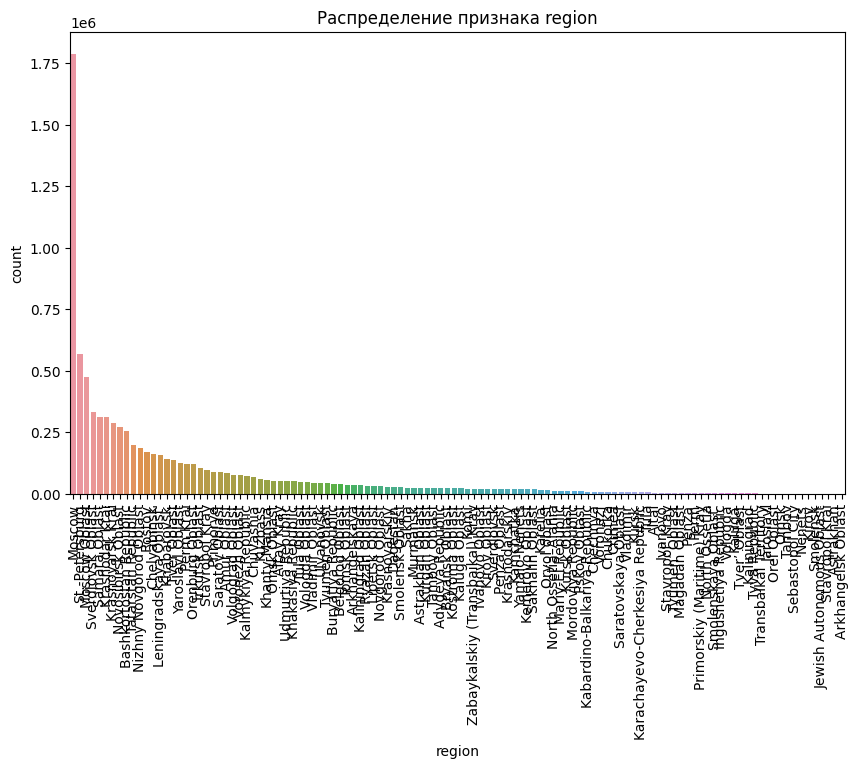

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


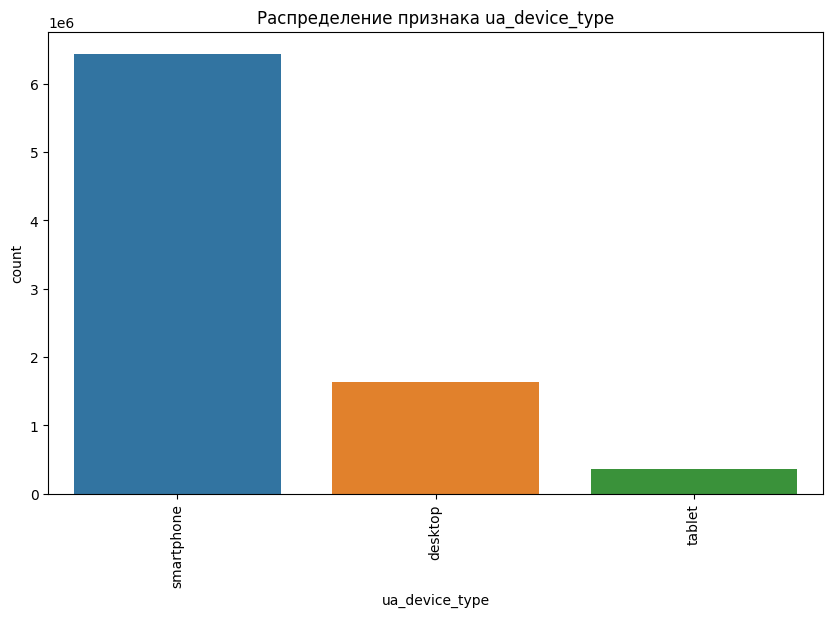

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


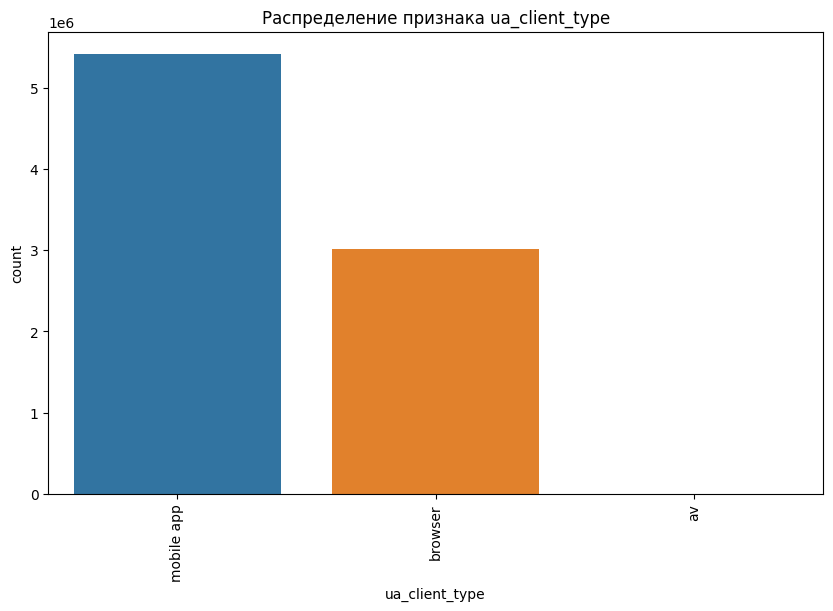

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


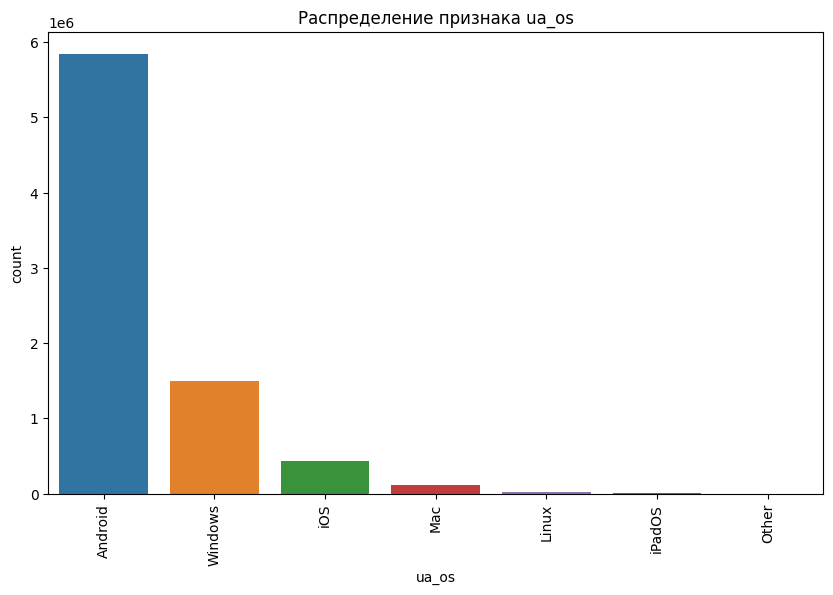

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


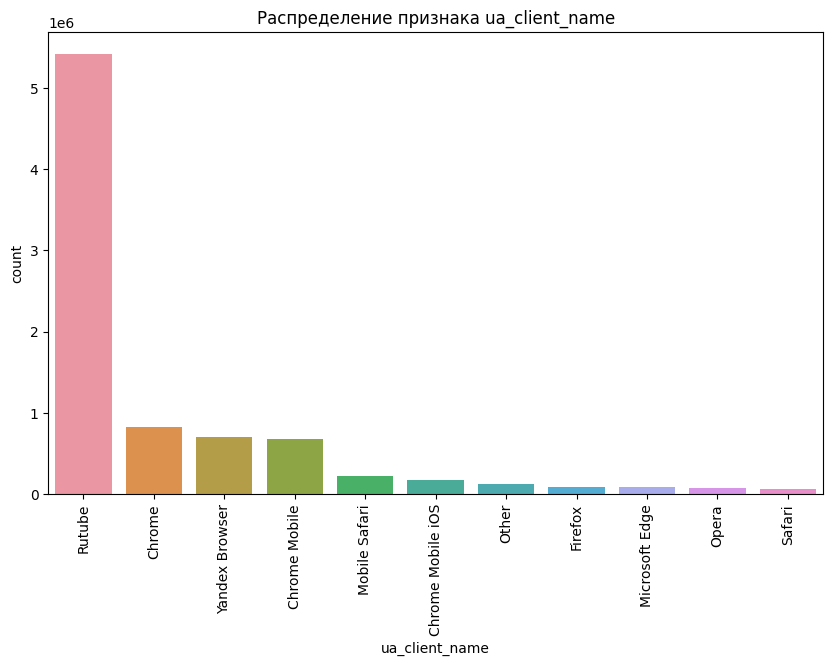

In [14]:
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=all_events, x=feature, order=all_events[feature].value_counts().index)
    plt.title(f'Распределение признака {feature}')
    plt.xticks(rotation=90)
    plt.show()

In [19]:
all_events.columns

Index(['region', 'ua_device_type', 'ua_client_type', 'ua_os', 'ua_client_name',
       'total_watchtime', 'rutube_video_id', 'viewer_uid',
       'local_event_timestamp', 'time_shift'],
      dtype='object')

## Анализ сдвига по времени в разных часовых поясах от Москвы

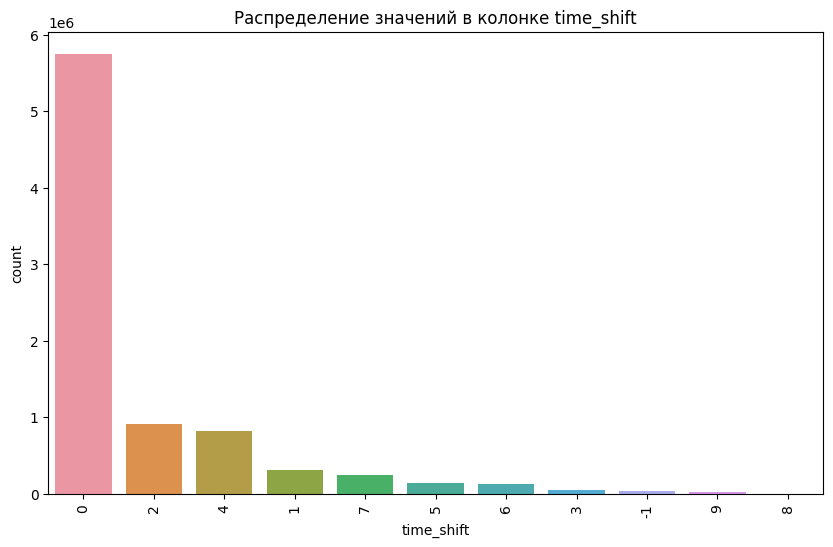

In [17]:
# Подсчет частотности значений в колонке time_shift
time_shift_counts = all_events['time_shift'].value_counts()

# Визуализация распределения значений
plt.figure(figsize=(10, 6))
sns.countplot(data=all_events, x='time_shift', order=time_shift_counts.index)
plt.title('Распределение значений в колонке time_shift')
plt.xticks(rotation=90)
plt.show()

## 4. Объединение таблиц, обогащение данными о видео

In [117]:
all_events.head()

,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,local_event_timestamp,time_shift
0,Tatarstan Republic,smartphone,browser,Android,Chrome Mobile,60,video_395879,10813370,2024-06-01 13:08:30+03:00,0
1,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,60,video_216518,10512324,2024-06-01 14:30:00+03:00,0
2,Novosibirsk Oblast,smartphone,mobile app,Android,Rutube,121,video_41225,10951137,2024-06-01 22:48:12+03:00,4
3,Moscow,desktop,browser,Windows,Yandex Browser,2324,video_215886,10912434,2024-06-01 16:32:36+03:00,0
4,Moscow Oblast,smartphone,mobile app,Android,Rutube,6830,video_43631,10223585,2024-06-01 00:57:04+03:00,0


In [15]:
# Объединение таблиц по столбцу rutube_video_id
all_merged_data = all_events.merge(video_info, on='rutube_video_id', how='left')

all_merged_data.head()

,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,title,category,duration,author_id
0,Tatarstan Republic,smartphone,browser,Android,Chrome Mobile,60,video_395879,10813370,ТАЙНА ДВОРЦОВОГО МОСТА В ПЕТЕРБУРГЕ | А ЧТО ПО...,Лайфстайл,333313,1012572
1,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,60,video_216518,10512324,"Я художник, я так вижу. Мужское / Женское. Вып...",Телепередачи,2500274,1009219
2,Novosibirsk Oblast,smartphone,mobile app,Android,Rutube,121,video_41225,10951137,ДОРАМЫ ПРО ЛЮБОВЬ ♥ Романтические Фильмы ♥ Кор...,Фильмы,257997,1023998
3,Moscow,desktop,browser,Windows,Yandex Browser,2324,video_215886,10912434,Менталист / The Mentalist – 4 сезон 13 серия,Сериалы,2363393,1074854
4,Moscow Oblast,smartphone,mobile app,Android,Rutube,6830,video_43631,10223585,Сериал Тёмная материя – 1 сезон 4 серия / Dark...,Сериалы,3589376,1036095


In [16]:
# Объединение таблиц по столбцу rutube_video_id
train_merged_data = train_events.merge(video_info, on='rutube_video_id', how='left')

train_merged_data.head(5)

,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,title,category,duration,author_id
0,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243,Папа с особенностями. Мужское / Женское. Выпус...,Телепередачи,2456534,1009219
1,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341,Comedy Club: Мальдивы | Андрей Бебуришвили,Юмор,519211,1006760
2,St.-Petersburg,desktop,browser,Windows,Chrome,5647,video_96775,10894333,"Новая Битва экстрасенсов, 24 сезон, 11 выпуск",Телепередачи,5518280,1009257
3,Moscow,smartphone,mobile app,Android,Rutube,1521,video_161610,10029092,Сергей Орлов-снял дом!!!,Разное,1522069,1058671
4,Moscow,smartphone,mobile app,Android,Rutube,71,video_116245,10452976,Ищем сокровища в Полевском | Уральская Флоренц...,Путешествия,1249920,1020020


In [19]:
len(merged_data['author_id'].unique())

83311

Признак: время суток

In [17]:
# Функция для определения времени суток
def determine_time_of_day(timestamp):
    hour = timestamp.hour
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'



In [121]:
# Применение функции к столбцу local_event_timestamp
all_merged_data['time_of_day'] = all_merged_data['local_event_timestamp'].apply(determine_time_of_day)
# Применение функции к столбцу local_event_timestamp
train_merged_data['time_of_day'] = train_merged_data['local_event_timestamp'].apply(determine_time_of_day)

## Признак: выходной день / Будний

In [122]:
# Функция для определения выходного дня
def is_weekend(timestamp):
    return timestamp.weekday() >= 5  # 5 - суббота, 6 - воскресенье

# Применение функции к столбцу local_event_timestamp
all_merged_data['is_weekend'] = all_merged_data['local_event_timestamp'].apply(is_weekend)
train_merged_data['is_weekend'] = train_merged_data['local_event_timestamp'].apply(is_weekend)

In [123]:
all_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8439624 entries, 0 to 8439623
Data columns (total 16 columns):
 #   Column                 Dtype                    
---  ------                 -----                    
 0   region                 category                 
 1   ua_device_type         category                 
 2   ua_client_type         category                 
 3   ua_os                  category                 
 4   ua_client_name         category                 
 5   total_watchtime        int32                    
 6   rutube_video_id        object                   
 7   viewer_uid             int32                    
 8   local_event_timestamp  datetime64[ns, UTC+03:00]
 9   time_shift             int64                    
 10  title                  object                   
 11  category               category                 
 12  duration               int32                    
 13  author_id              int32                    
 14  time_of_day       

In [124]:
all_merged_data['time_of_day'].value_counts() 

time_of_day
Evening      2954978
Afternoon    2420974
Morning      1758825
Night        1304847
Name: count, dtype: int64

In [18]:
# Преобразование столбца duration в секунды
all_merged_data['duration'] = all_merged_data['duration'] / 1000
train_merged_data['duration'] = train_merged_data['duration'] / 1000

## Анализ продолжительности видео для каждого author_id

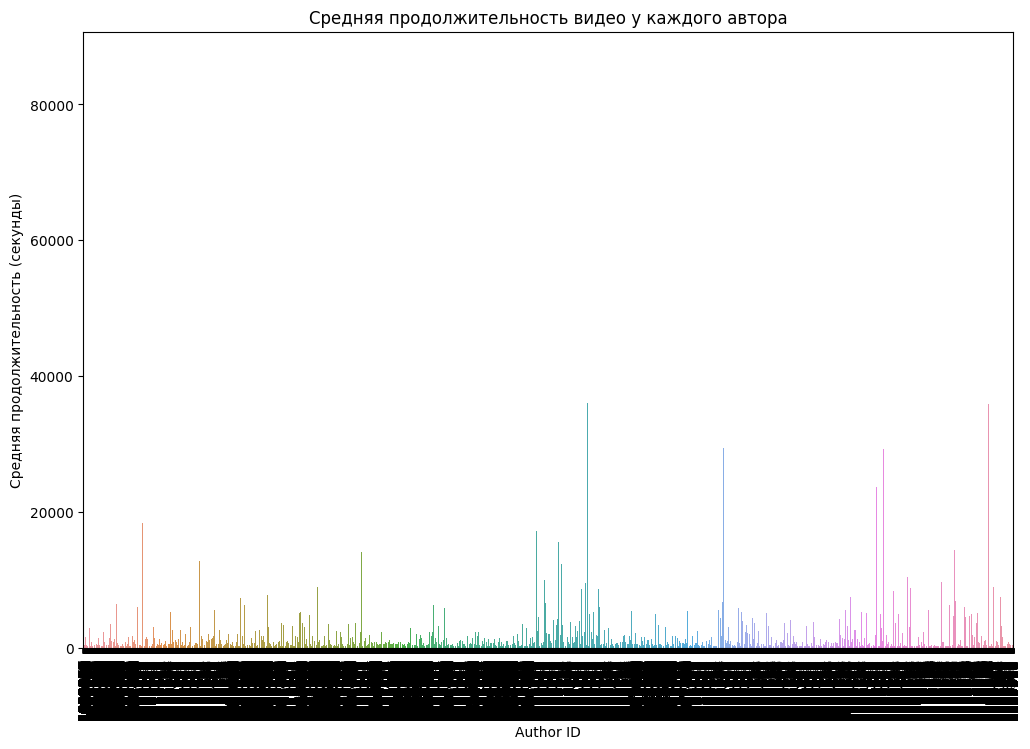

In [48]:


# Расчет средней продолжительности видео для каждого author_id
average_duration_per_author = all_merged_data.groupby('author_id')['duration'].mean().reset_index()

# Построение графика
plt.figure(figsize=(12, 8))
sns.barplot(data=average_duration_per_author, x='author_id', y='duration_seconds')
plt.title('Средняя продолжительность видео у каждого автора')
plt.xlabel('Author ID')
plt.ylabel('Средняя продолжительность (секунды)')
plt.xticks(rotation=90)
plt.show()

In [55]:
average_duration_per_author['duration_seconds'].tolist()

[344.0232142857143,
 236.52,
 458.8605,
 2307.229185379263,
 438.16746465191585,
 252.2502,
 794.6095,
 1852.4925301326737,
 279.82666666666665,
 3038.64,
 217.286,
 225.4712079414838,
 223.11,
 430.1523157894737,
 2700.2060084396103,
 211.36,
 338.43675,
 626.9402592592592,
 253.6208333333333,
 698.16,
 258.166,
 300.063,
 2578.220480952381,
 450.176,
 228.647,
 396.54,
 205.078,
 308.27,
 424.55949999999996,
 189.32,
 188.729,
 522.5020166259169,
 257.6414,
 1389.9074522417154,
 3275.2913529975667,
 1486.2791604446656,
 407.66766666666666,
 1115.23855,
 647.571,
 1239.8248333333333,
 841.8715,
 1500.1965,
 1176.9253333333334,
 1290.026,
 1212.9292500000001,
 208.738,
 890.4853333333334,
 2676.475,
 952.53,
 460.083,
 572.192,
 278.613,
 780.5699999999999,
 239.4925,
 2275.712317460317,
 258.77,
 509.24119999999994,
 1645.42,
 270.195,
 1282.0,
 1858.8290000000002,
 226.508,
 766.655,
 301.975,
 2892.0485714285714,
 466.0,
 446.27,
 2523.6957142857145,
 908.4306666666668,
 793.294,
 1

## Анализ: частотность категорий видео

In [57]:
# Подсчет частотности категорий видео
category_counts = merged_data['category'].value_counts()

# Выбор первых трех наиболее распространенных категорий
top_categories = category_counts.head(3).index

# Фильтрация данных по первым трем категориям
filtered_data = merged_data[merged_data['category'].isin(top_categories)]

In [58]:
# Подсчет частотности категорий в каждом часовом поясе
time_shift_category_counts = filtered_data.groupby(['time_shift', 'category']).size().unstack(fill_value=0)

/tmp/ipykernel_30/2917503217.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_shift_category_counts = filtered_data.groupby(['time_shift', 'category']).size().unstack(fill_value=0)


In [59]:
# Определение наиболее распространенных категорий в каждом часовом поясе
most_common_categories = time_shift_category_counts.idxmax(axis=1)


In [60]:
# Проверка результатов
print(most_common_categories)

time_shift
-1    Телепередачи
 0    Телепередачи
 1    Телепередачи
 2    Телепередачи
 3    Телепередачи
 4    Телепередачи
 5    Телепередачи
 6    Телепередачи
 7    Телепередачи
 8    Телепередачи
 9    Телепередачи
dtype: category
Categories (40, object): ['Авто-мото', 'Аниме', 'Аудио', 'Аудиокниги', ..., 'Фильмы', 'Хобби', 'Эзотерика', 'Юмор']


In [61]:
# Подсчет частотности категорий в каждом часовом поясе
time_shift_category_counts = merged_data.groupby(['time_shift', 'category']).size().unstack(fill_value=0)
# Определение пяти наиболее распространенных категорий в каждом часовом поясе
top_categories_per_time_shift = time_shift_category_counts.apply(lambda x: x.nlargest(5).index.tolist(), axis=1)
# Проверка результатов
print(top_categories_per_time_shift)

/tmp/ipykernel_30/3980642153.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_shift_category_counts = merged_data.groupby(['time_shift', 'category']).size().unstack(fill_value=0)


time_shift
-1    [Телепередачи, Сериалы, Фильмы, Разное, Путеше...
 0    [Телепередачи, Сериалы, Фильмы, Развлечения, Р...
 1    [Телепередачи, Сериалы, Развлечения, Фильмы, Л...
 2    [Телепередачи, Сериалы, Фильмы, Развлечения, Р...
 3    [Телепередачи, Сериалы, Фильмы, Разное, Интервью]
 4    [Телепередачи, Сериалы, Развлечения, Фильмы, Р...
 5    [Телепередачи, Сериалы, Фильмы, Разное, Развле...
 6    [Телепередачи, Сериалы, Фильмы, Разное, Развле...
 7    [Телепередачи, Сериалы, Красота, Интервью, Фил...
 8    [Телепередачи, Сериалы, Фильмы, Разное, Интервью]
 9    [Телепередачи, Сериалы, Фильмы, Разное, Интервью]
dtype: object


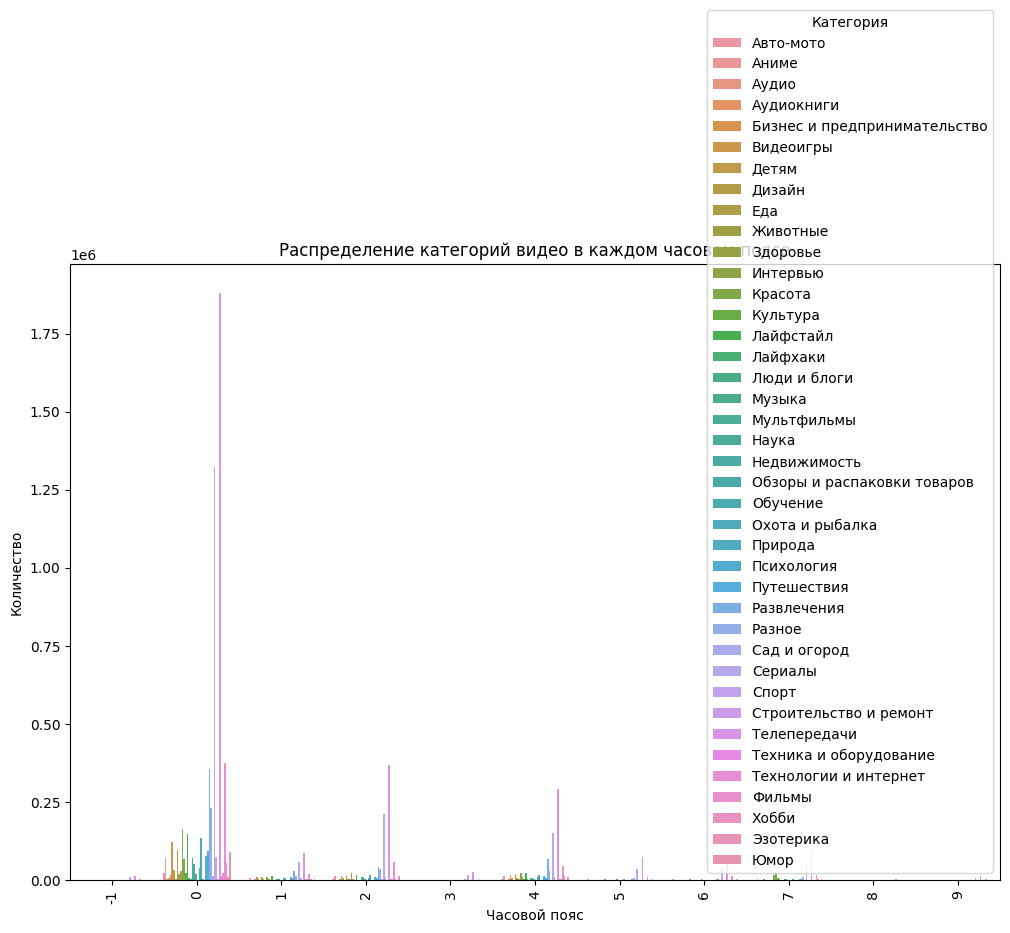

In [62]:
# Визуализация распределения категорий в каждом часовом поясе
plt.figure(figsize=(12, 8))
sns.countplot(data=merged_data, x='time_shift', hue='category', order=time_shift_category_counts.index)
plt.title('Распределение категорий видео в каждом часовом поясе')
plt.xlabel('Часовой пояс')
plt.ylabel('Количество')
plt.legend(title='Категория')
plt.xticks(rotation=90)
plt.show()

In [63]:
# Создание списка всех категорий, которые нужно отобразить
all_top_categories = set(top_categories_per_time_shift.explode().unique())

# Фильтрация данных для визуализации
filtered_data = merged_data[merged_data['category'].isin(all_top_categories)]

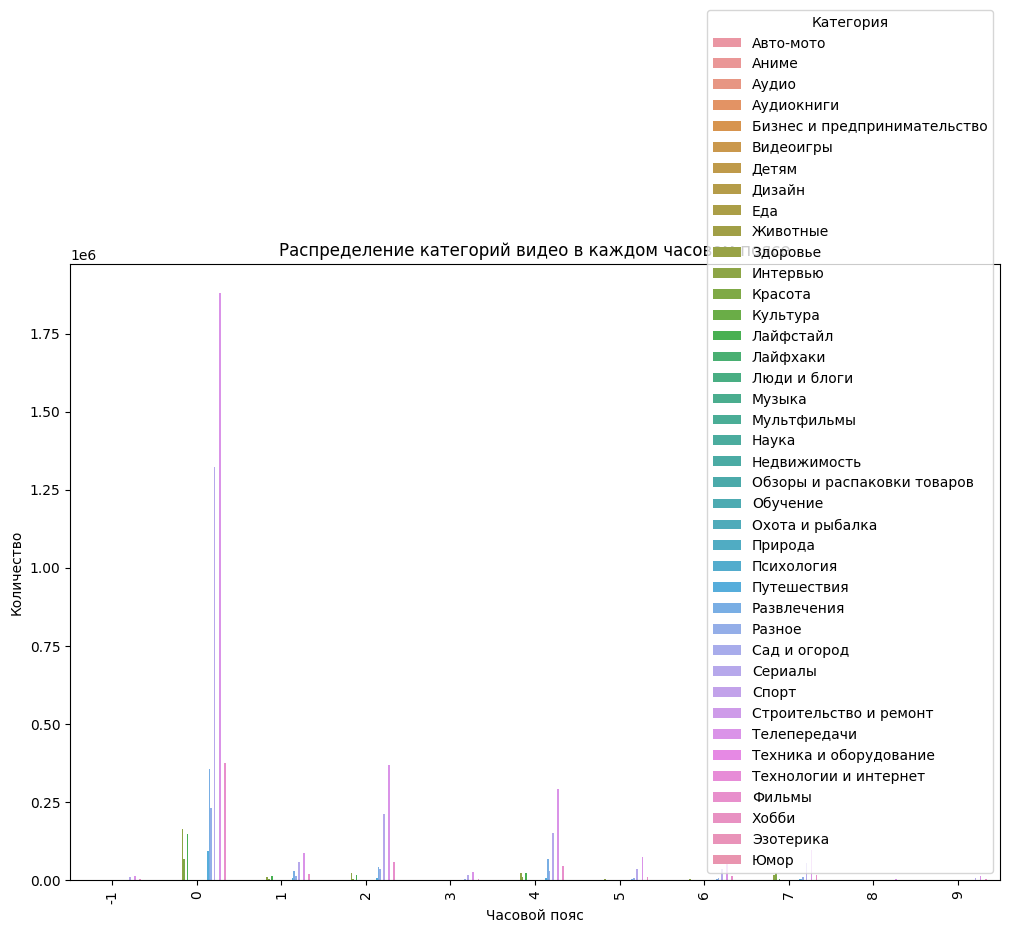

In [64]:
# Визуализация распределения категорий в каждом часовом поясе
plt.figure(figsize=(12, 8))
sns.countplot(data=filtered_data, x='time_shift', hue='category', order=time_shift_category_counts.index)
plt.title('Распределение категорий видео в каждом часовом поясе')
plt.xlabel('Часовой пояс')
plt.ylabel('Количество')
plt.legend(title='Категория')
plt.xticks(rotation=90)
plt.show()

In [26]:
merged_data['category'].value_counts()

category
Телепередачи                    2909742
Сериалы                         1896951
Фильмы                           542666
Развлечения                      505899
Разное                           332363
Интервью                         236710
Лайфстайл                        206342
Обучение                         177980
Видеоигры                        165028
Еда                              135766
Юмор                             126262
Путешествия                      115035
Психология                       109041
Красота                          106976
Аниме                            106972
Спорт                            101396
Музыка                            94994
Хобби                             76775
Мультфильмы                       76281
Обзоры и распаковки товаров       60851
Детям                             48392
Здоровье                          37234
Культура                          34783
Технологии и интернет             33072
Животные                       

In [27]:
merged_data.head(5)

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,local_event_timestamp,time_shift,title,category,duration,author_id,time_of_day,is_weekend,duration_seconds
0,2024-06-01 13:08:30+03:00,Tatarstan Republic,smartphone,browser,Android,Chrome Mobile,60,video_395879,10813370,2024-06-01 13:08:30+03:00,0,ТАЙНА ДВОРЦОВОГО МОСТА В ПЕТЕРБУРГЕ | А ЧТО ПО...,Лайфстайл,333313,1012572,Afternoon,True,333.313
1,2024-06-01 14:30:00+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,60,video_216518,10512324,2024-06-01 14:30:00+03:00,0,"Я художник, я так вижу. Мужское / Женское. Вып...",Телепередачи,2500274,1009219,Afternoon,True,2500.274
2,2024-06-01 18:48:12+03:00,Novosibirsk Oblast,smartphone,mobile app,Android,Rutube,121,video_41225,10951137,2024-06-01 22:48:12+03:00,4,ДОРАМЫ ПРО ЛЮБОВЬ ♥ Романтические Фильмы ♥ Кор...,Фильмы,257997,1023998,Evening,True,257.997
3,2024-06-01 16:32:36+03:00,Moscow,desktop,browser,Windows,Yandex Browser,2324,video_215886,10912434,2024-06-01 16:32:36+03:00,0,Менталист / The Mentalist – 4 сезон 13 серия,Сериалы,2363393,1074854,Afternoon,True,2363.393
4,2024-06-01 00:57:04+03:00,Moscow Oblast,smartphone,mobile app,Android,Rutube,6830,video_43631,10223585,2024-06-01 00:57:04+03:00,0,Сериал Тёмная материя – 1 сезон 4 серия / Dark...,Сериалы,3589376,1036095,Night,True,3589.376


## Признак: наиболее частая категория среди просмотренных пользователем

In [19]:
# Подсчет частотности категорий для каждого viewer_uid
category_counts = all_merged_data.groupby(['viewer_uid', 'category']).size().unstack(fill_value=0)

# Определение наиболее частой категории для каждого viewer_uid
most_common_category = category_counts.idxmax(axis=1)

# Добавление новой колонки с наиболее частой категорией
all_merged_data = all_merged_data.merge(most_common_category.reset_index(), on='viewer_uid', how='left')
all_merged_data.rename(columns={'category': 'most_common_category'}, inplace=True)

# Проверка результатов
all_merged_data.head()

/tmp/ipykernel_30/4077739913.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_counts = all_merged_data.groupby(['viewer_uid', 'category']).size().unstack(fill_value=0)


,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,title,most_common_category,duration,author_id,0
0,Tatarstan Republic,smartphone,browser,Android,Chrome Mobile,60,video_395879,10813370,ТАЙНА ДВОРЦОВОГО МОСТА В ПЕТЕРБУРГЕ | А ЧТО ПО...,Лайфстайл,333.313,1012572,Развлечения
1,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,60,video_216518,10512324,"Я художник, я так вижу. Мужское / Женское. Вып...",Телепередачи,2500.274,1009219,Телепередачи
2,Novosibirsk Oblast,smartphone,mobile app,Android,Rutube,121,video_41225,10951137,ДОРАМЫ ПРО ЛЮБОВЬ ♥ Романтические Фильмы ♥ Кор...,Фильмы,257.997,1023998,Сериалы
3,Moscow,desktop,browser,Windows,Yandex Browser,2324,video_215886,10912434,Менталист / The Mentalist – 4 сезон 13 серия,Сериалы,2363.393,1074854,Телепередачи
4,Moscow Oblast,smartphone,mobile app,Android,Rutube,6830,video_43631,10223585,Сериал Тёмная материя – 1 сезон 4 серия / Dark...,Сериалы,3589.376,1036095,Сериалы


In [20]:
# Переименование колонки 0 в category
all_merged_data.rename(columns={0: 'category'}, inplace=True)

In [128]:
all_merged_data.columns

Index(['region', 'ua_device_type', 'ua_client_type', 'ua_os', 'ua_client_name',
       'total_watchtime', 'rutube_video_id', 'viewer_uid',
       'local_event_timestamp', 'time_shift', 'title', 'most_common_category',
       'duration', 'author_id', 'time_of_day', 'is_weekend', 'category'],
      dtype='object')

In [21]:
# Подсчет частотности категорий для каждого viewer_uid
category_counts = train_merged_data.groupby(['viewer_uid', 'category']).size().unstack(fill_value=0)

# Определение наиболее частой категории для каждого viewer_uid
most_common_category = category_counts.idxmax(axis=1)

# Добавление новой колонки с наиболее частой категорией
train_merged_data = train_merged_data.merge(most_common_category.reset_index(), on='viewer_uid', how='left')
train_merged_data.rename(columns={'category': 'most_common_category'}, inplace=True)

# Проверка результатов
train_merged_data.head()

/tmp/ipykernel_30/4196316558.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_counts = train_merged_data.groupby(['viewer_uid', 'category']).size().unstack(fill_value=0)


,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,title,most_common_category,duration,author_id,0
0,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243,Папа с особенностями. Мужское / Женское. Выпус...,Телепередачи,2456.534,1009219,Телепередачи
1,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341,Comedy Club: Мальдивы | Андрей Бебуришвили,Юмор,519.211,1006760,Телепередачи
2,St.-Petersburg,desktop,browser,Windows,Chrome,5647,video_96775,10894333,"Новая Битва экстрасенсов, 24 сезон, 11 выпуск",Телепередачи,5518.280,1009257,Телепередачи
3,Moscow,smartphone,mobile app,Android,Rutube,1521,video_161610,10029092,Сергей Орлов-снял дом!!!,Разное,1522.069,1058671,Разное
4,Moscow,smartphone,mobile app,Android,Rutube,71,video_116245,10452976,Ищем сокровища в Полевском | Уральская Флоренц...,Путешествия,1249.920,1020020,Телепередачи


In [22]:
# Переименование колонки 0 в category
train_merged_data.rename(columns={0: 'category'}, inplace=True)

In [ ]:
Признак: доля просмотренного видео

In [23]:
# Расчет доли просмотренного видео
all_merged_data['watch_ratio'] = all_merged_data['total_watchtime'] / all_merged_data['duration']
train_merged_data['watch_ratio'] = train_merged_data['total_watchtime'] / train_merged_data['duration']

## Анализ: Распределение доли просмотренного видео

In [132]:
import numpy as np

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


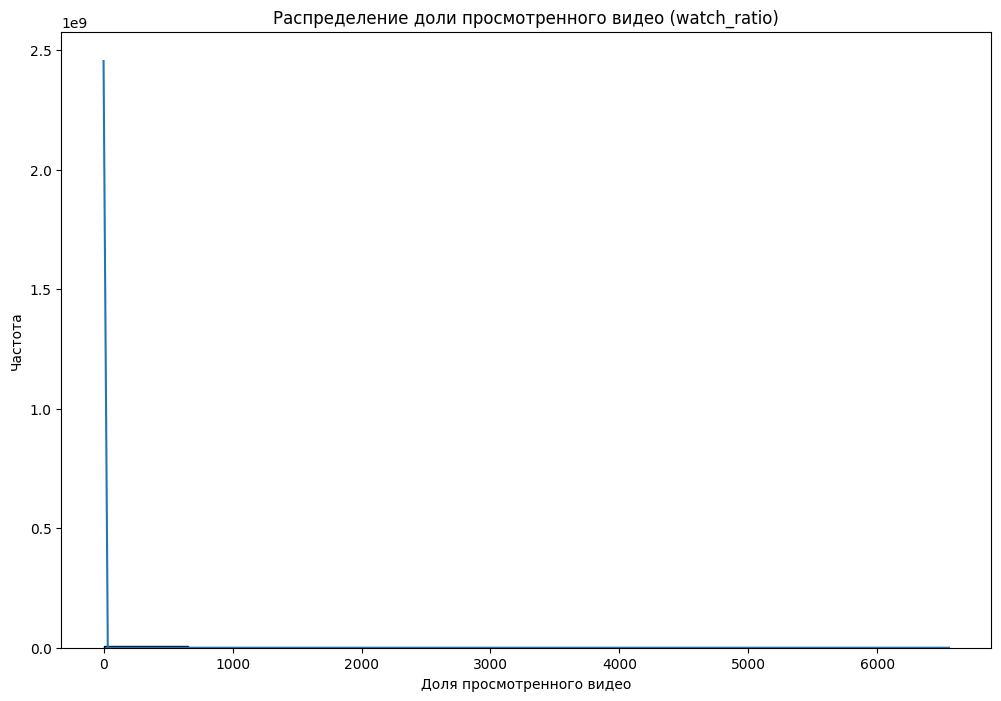

In [39]:
# Построение графика распределения watch_ratio
plt.figure(figsize=(12, 8))
sns.histplot(all_merged_data['watch_ratio'], bins=10, kde=True)
plt.title('Распределение доли просмотренного видео (watch_ratio)')
plt.xlabel('Доля просмотренного видео')
plt.ylabel('Частота')
plt.show()

In [42]:
all_merged_data['watch_ratio'].median()

0.6941266209000763

In [41]:
all_merged_data.head(2)

,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,local_event_timestamp,time_shift,title,most_common_category,duration,author_id,time_of_day,is_weekend,category,watch_ratio
0,Tatarstan Republic,smartphone,browser,Android,Chrome Mobile,60,video_395879,10813370,2024-06-01 13:08:30+03:00,0,ТАЙНА ДВОРЦОВОГО МОСТА В ПЕТЕРБУРГЕ | А ЧТО ПО...,Лайфстайл,333.313,1012572,Afternoon,True,Развлечения,0.180011
1,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,60,video_216518,10512324,2024-06-01 14:30:00+03:00,0,"Я художник, я так вижу. Мужское / Женское. Вып...",Телепередачи,2500.274,1009219,Afternoon,True,Телепередачи,0.023997


In [24]:
#ограничим врхнюю границу доли просмотров 1, а значит пользователь промотрел доконца или несколько раз просмотрел видео одинаково
all_merged_data['watch_ratio'] = all_merged_data['watch_ratio'].clip(upper=1)
train_merged_data['watch_ratio'] = train_merged_data['watch_ratio'].clip(upper=1)

In [43]:
all_merged_data.columns 

Index(['region', 'ua_device_type', 'ua_client_type', 'ua_os', 'ua_client_name',
       'total_watchtime', 'rutube_video_id', 'viewer_uid',
       'local_event_timestamp', 'time_shift', 'title', 'most_common_category',
       'duration', 'author_id', 'time_of_day', 'is_weekend', 'category',
       'watch_ratio'],
      dtype='object')

Признак: создаем комбинированные признаки

In [25]:
all_merged_data['browser_os'] = all_merged_data['ua_client_name'].astype(str) + '_' + all_merged_data['ua_os'].astype(str)
all_merged_data['device_client'] = all_merged_data['ua_device_type'].astype(str) + '_' + all_merged_data['ua_client_type'].astype(str)
all_merged_data['browser_os_device'] = all_merged_data['ua_client_name'].astype(str) + '_' + all_merged_data['ua_os'].astype(str) + '_' + all_merged_data['ua_device_type'].astype(str)

In [26]:
train_merged_data['browser_os'] = train_merged_data['ua_client_name'].astype(str) + '_' + train_merged_data['ua_os'].astype(str)
train_merged_data['device_client'] = train_merged_data['ua_device_type'].astype(str) + '_' + train_merged_data['ua_client_type'].astype(str)
train_merged_data['browser_os_device'] = train_merged_data['ua_client_name'].astype(str) + '_' + train_merged_data['ua_os'].astype(str) + '_' + train_merged_data['ua_device_type'].astype(str)

In [100]:
train_merged_data.columns

Index(['region', 'ua_device_type', 'ua_client_type', 'ua_os', 'ua_client_name',
       'total_watchtime', 'rutube_video_id', 'viewer_uid',
       'local_event_timestamp', 'time_shift', 'title', 'most_common_category',
       'duration', 'author_id', 'time_of_day', 'is_weekend', 'category',
       'watch_ratio', 'browser_os', 'device_client', 'browser_os_device'],
      dtype='object')

In [27]:
none_model_columns=['local_event_timestamp', 'rutube_video_id','viewer_uid']

Анализ: распределение длительности видео

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


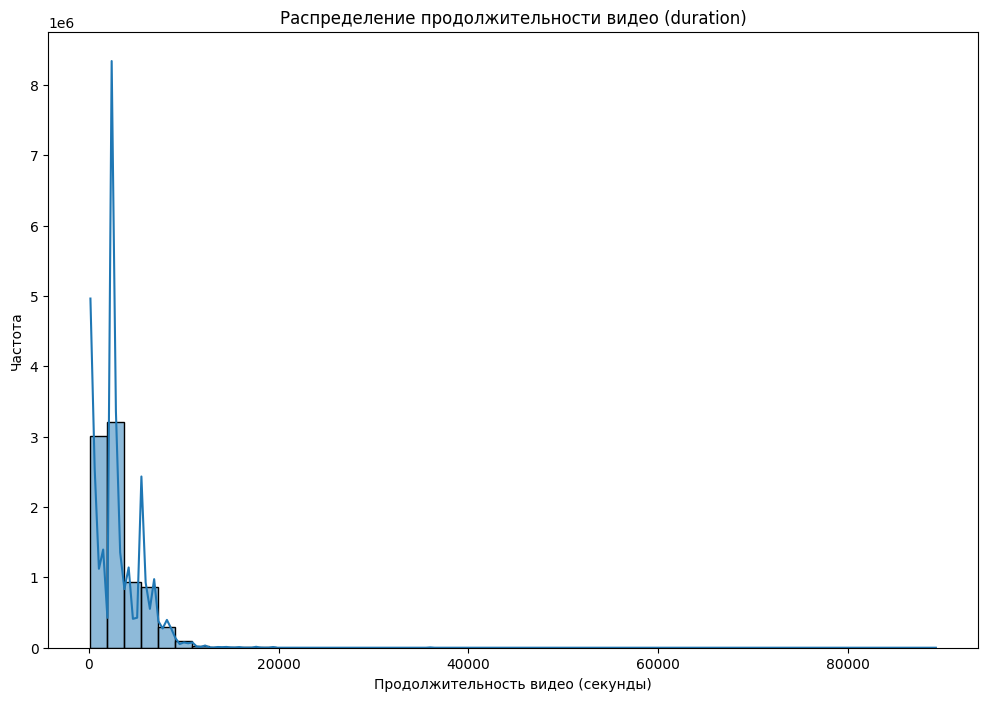

In [48]:
# Построение графика распределения duration
plt.figure(figsize=(12, 8))
sns.histplot(all_merged_data['duration'], bins=50, kde=True)
plt.title('Распределение продолжительности видео (duration)')
plt.xlabel('Продолжительность видео (секунды)')
plt.ylabel('Частота')
plt.show()

In [50]:
# Подсчет количества значений, больших 10000
count_greater_than_10000 = (all_merged_data['duration'] > 10000).sum()
# Общее количество значений
total_count = all_merged_data['duration'].count()

# Расчет доли значений, больших 10000
fraction_greater_than_10000 = count_greater_than_10000 / total_count
fraction_greater_than_10000

0.011527883232712737

чуть более 1% видео длиннее 1000с

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


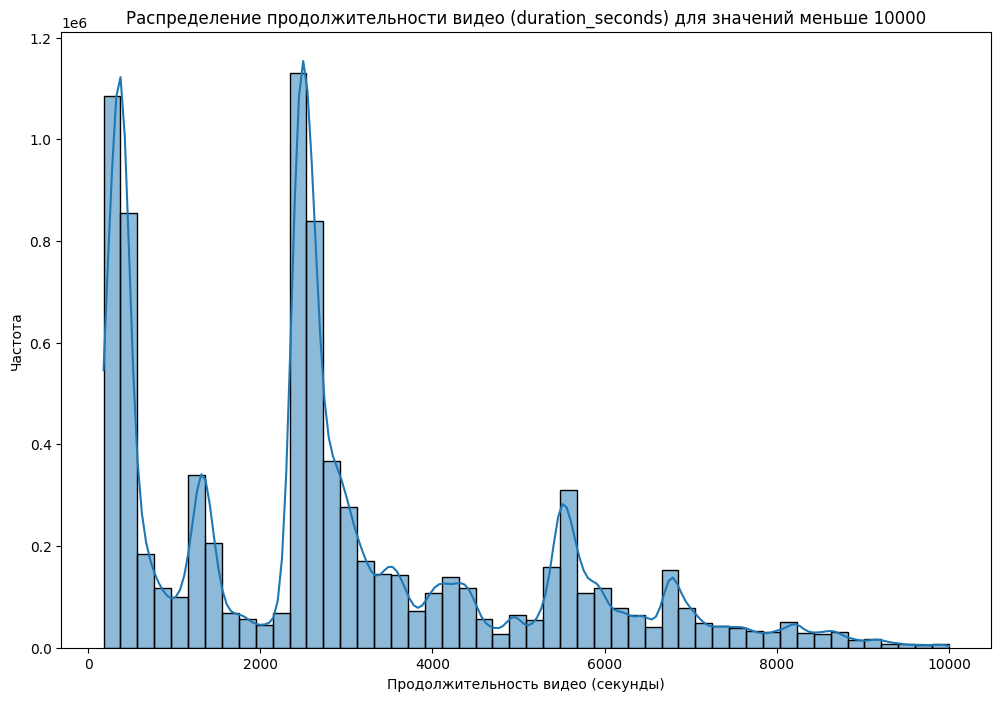

In [51]:
filtered_data = all_merged_data[all_merged_data['duration'] < 10000]

# Построение графика распределения duration_seconds
plt.figure(figsize=(12, 8))
sns.histplot(filtered_data['duration'], bins=50, kde=True)
plt.title('Распределение продолжительности видео (duration_seconds) для значений меньше 10000')
plt.xlabel('Продолжительность видео (секунды)')
plt.ylabel('Частота')
plt.show()

Признак: продолжиельность видео заменим на категории по продолжительности: 

In [28]:
#Дискретизация колонки duration

# 0-900 - короткие видео
# 900-2000 - небольшие обясняющие видео
# 2000-3600 - 45 мин-1 час серия в сериалах
# 3600-4800 - 1-1,5ч. телепередача/ фильм
# 4800-6800 - фильм
# 6800-10000 - продолжительное видео в несколько серий
# 10000 и max - залитые сезоны

# Определение диапазонов
bins = [0, 900, 2000, 3600, 4800, 6800, 10000, float('inf')]
labels = ['0-900', '900-2000', '2000-3600', '3600-4800', '4800-6800', '6800-10000', '10000 и max']

# Дискретизация колонки duration
all_merged_data['duration_category'] = pd.cut(all_merged_data['duration'], bins=bins, labels=labels, right=False)
train_merged_data['duration_category'] = pd.cut(train_merged_data['duration'], bins=bins, labels=labels, right=False)

In [138]:
train_merged_data.head(5)

,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,local_event_timestamp,time_shift,...,duration,author_id,time_of_day,is_weekend,category,watch_ratio,browser_os,device_client,browser_os_device,duration_category
0,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243,2024-06-01 08:40:58+03:00,2,...,2456.534,1009219,Morning,True,Телепередачи,0.766527,Yandex Browser_Windows,desktop_browser,Yandex Browser_Windows_desktop,2000-3600
1,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341,2024-06-01 19:33:24+03:00,0,...,519.211,1006760,Evening,True,Телепередачи,0.986112,Rutube_Android,smartphone_mobile app,Rutube_Android_smartphone,0-900
2,St.-Petersburg,desktop,browser,Windows,Chrome,5647,video_96775,10894333,2024-06-01 21:30:43+03:00,0,...,5518.280,1009257,Evening,True,Телепередачи,1.000000,Chrome_Windows,desktop_browser,Chrome_Windows_desktop,4800-6800
3,Moscow,smartphone,mobile app,Android,Rutube,1521,video_161610,10029092,2024-06-01 23:03:42+03:00,0,...,1522.069,1058671,Evening,True,Разное,0.999298,Rutube_Android,smartphone_mobile app,Rutube_Android_smartphone,900-2000
4,Moscow,smartphone,mobile app,Android,Rutube,71,video_116245,10452976,2024-06-01 22:48:09+03:00,0,...,1249.920,1020020,Evening,True,Телепередачи,0.056804,Rutube_Android,smartphone_mobile app,Rutube_Android_smartphone,900-2000


Признак: обработка заголовка видео с помощью частотных характеристик

In [12]:
# import re

# def clean_text(text):
#     # Удаление спецсимволов и лишних пробелов
#     text = re.sub(r'[^\w\s]', '', text)
#     # Приведение к нижнему регистру
#     text = text.lower()
#     return text

In [13]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# merged_data['clean_title'] = merged_data['title'].apply(clean_text)

# tfidf_vectorizer = TfidfVectorizer(max_features=10)
# tfidf_matrix = tfidf_vectorizer.fit_transform(merged_data['clean_title'])

# tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"tfidf_{i}" for i in range(tfidf_matrix.shape[1])])

# merged_data = pd.concat([merged_data, tfidf_df], axis=1)

# merged_data.head(5)

,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,time_shift,title,most_common_category,author_id,...,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9
0,Tatarstan Republic,smartphone,browser,Android,Chrome Mobile,60,0,ТАЙНА ДВОРЦОВОГО МОСТА В ПЕТЕРБУРГЕ | А ЧТО ПО...,Лайфстайл,1012572,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,60,0,"Я художник, я так вижу. Мужское / Женское. Вып...",Телепередачи,1009219,...,0.0,0.377117,0.547808,0.547814,0.0,0.0,0.507533,0.000000,0.000000,0.000000
2,Novosibirsk Oblast,smartphone,mobile app,Android,Rutube,121,4,ДОРАМЫ ПРО ЛЮБОВЬ ♥ Романтические Фильмы ♥ Кор...,Фильмы,1023998,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,Moscow,desktop,browser,Windows,Yandex Browser,2324,0,Менталист / The Mentalist – 4 сезон 13 серия,Сериалы,1074854,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.667541,0.000000,0.744573
4,Moscow Oblast,smartphone,mobile app,Android,Rutube,6830,0,Сериал Тёмная материя – 1 сезон 4 серия / Dark...,Сериалы,1036095,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.439704,0.752412,0.490445


Анализ: редко встречаемые категории видео

In [54]:
all_merged_data.columns

Index(['region', 'ua_device_type', 'ua_client_type', 'ua_os', 'ua_client_name',
       'total_watchtime', 'rutube_video_id', 'viewer_uid',
       'local_event_timestamp', 'time_shift', 'title', 'most_common_category',
       'duration', 'author_id', 'time_of_day', 'is_weekend', 'category',
       'watch_ratio', 'duration_category'],
      dtype='object')

In [55]:
all_merged_data['category'].value_counts()

category
Телепередачи                    3050150
Сериалы                         2031075
Развлечения                      726473
Фильмы                           443560
Интервью                         254864
Разное                           227547
Лайфстайл                        206137
Обучение                         187324
Видеоигры                        184888
Еда                              151460
Аниме                            116402
Красота                          109698
Психология                        98272
Путешествия                       89230
Юмор                              72835
Музыка                            69854
Мультфильмы                       62760
Спорт                             56090
Детям                             41796
Здоровье                          36303
Авто-мото                         32748
Хобби                             27477
Обзоры и распаковки товаров       27171
Культура                          22410
Животные                       

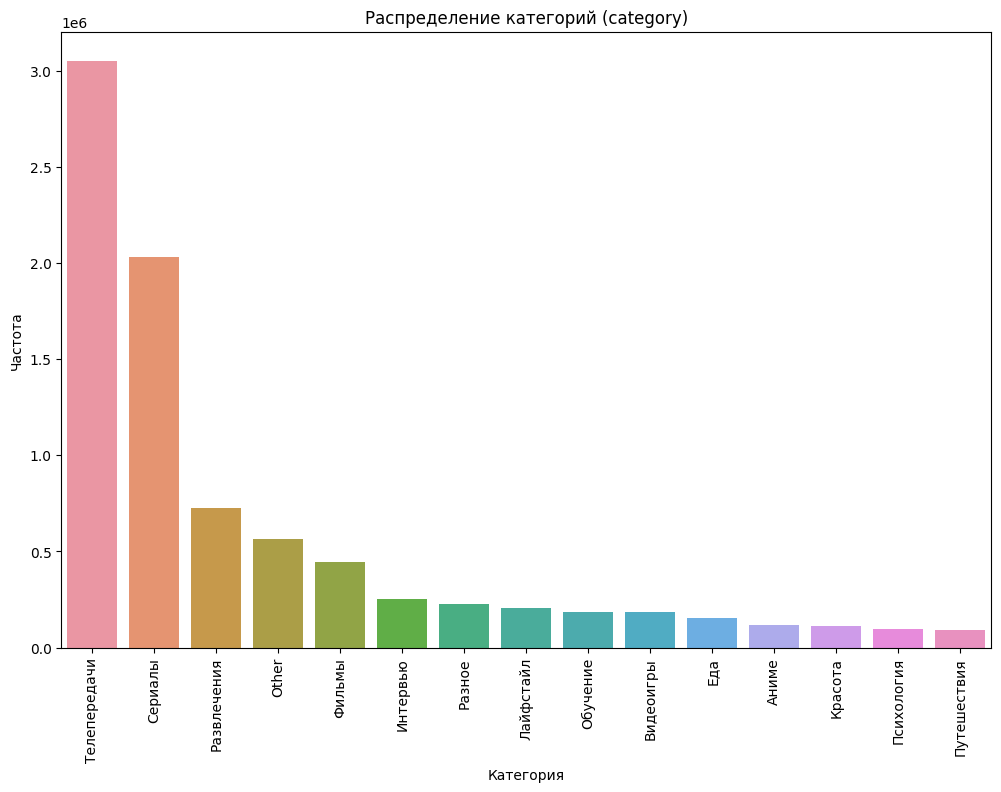

In [38]:
# Подсчет частотности категорий
category_counts = all_merged_data['category'].value_counts()

# Сортировка категорий по убыванию
category_counts_sorted = category_counts.sort_values(ascending=False)

# Построение графика распределения category
plt.figure(figsize=(12, 8))
sns.barplot(x=category_counts_sorted.index, y=category_counts_sorted.values)
plt.title('Распределение категорий (category)')
plt.xlabel('Категория')
plt.ylabel('Частота')
plt.xticks(rotation=90)
plt.show()

Заменяем редкие категории на Other

In [29]:
# Подсчет частотности категорий
value_counts = all_merged_data['category'].value_counts(normalize=True)
# Порог для объединения малочастотных значений (0.01%)
threshold_percentage = 0.01

# Определение малочастотных категорий
rare_categories = value_counts[value_counts < threshold_percentage].index

all_merged_data1 = all_merged_data.copy()

# Замена малочастотных категорий на "Other"
all_merged_data['category'] = all_merged_data['category'].replace(rare_categories, 'Other')
# Проверка результатов
print(all_merged_data['category'].value_counts())

category
Телепередачи    3050150
Сериалы         2031075
Развлечения      726473
Other            562544
Фильмы           443560
Интервью         254864
Разное           227547
Лайфстайл        206137
Обучение         187324
Видеоигры        184888
Еда              151460
Аниме            116402
Красота          109698
Психология        98272
Путешествия       89230
Name: count, dtype: int64


/tmp/ipykernel_30/3116705557.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  all_merged_data['category'] = all_merged_data['category'].replace(rare_categories, 'Other')


In [30]:
# Определяем уникальные значения признака из первого набора данных
unique_categories = all_merged_data['category'].unique()

# Копируем второй DataFrame для сохранения оригинала
train_merged_data = train_merged_data.copy()

# Замена всех значений, которые не входят в список уникальных значений, на "Other"
train_merged_data['category'] = train_merged_data['category'].apply(lambda x: x if x in unique_categories else 'Other')

In [141]:
train_merged_data['category'].value_counts()

category
Телепередачи    868010
Сериалы         449035
Other            91971
Фильмы           82641
Обучение         55007
Видеоигры        47998
Интервью         42807
Разное           38063
Развлечения      36361
Аниме            14015
Еда              13377
Лайфстайл        11545
Красота           4825
Путешествия       2971
Психология         990
Name: count, dtype: int64

Таже обработка для колонки most_common_category

In [31]:
# Подсчет частотности категорий
value_counts = all_merged_data['most_common_category'].value_counts(normalize=True)
# Порог для объединения малочастотных значений (0.01%)
threshold_percentage = 0.01

# Определение малочастотных категорий
rare_categories = value_counts[value_counts < threshold_percentage].index

all_merged_data1 = all_merged_data.copy()

# Замена малочастотных категорий на "Other"
all_merged_data['most_common_category'] = all_merged_data['most_common_category'].replace(rare_categories, 'Other')
# Проверка результатов
print(all_merged_data['most_common_category'].value_counts())

most_common_category
Телепередачи    2909742
Сериалы         1896951
Other            569501
Фильмы           542666
Развлечения      505899
Разное           332363
Интервью         236710
Лайфстайл        206342
Обучение         177980
Видеоигры        165028
Еда              135766
Юмор             126262
Путешествия      115035
Психология       109041
Красота          106976
Аниме            106972
Спорт            101396
Музыка            94994
Name: count, dtype: int64


/tmp/ipykernel_30/3744050318.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  all_merged_data['most_common_category'] = all_merged_data['most_common_category'].replace(rare_categories, 'Other')


In [32]:
# Определяем уникальные значения признака из первого набора данных
unique_categories = all_merged_data['most_common_category'].unique()

# Копируем второй DataFrame для сохранения оригинала
train_merged_data1 = train_merged_data.copy()

# Замена всех значений, которые не входят в список уникальных значений, на "Other"
train_merged_data['most_common_category'] = train_merged_data['most_common_category'].apply(lambda x: x if x in unique_categories else 'Other')

In [144]:
train_merged_data['most_common_category']

0          Телепередачи
1                  Юмор
2          Телепередачи
3                Разное
4           Путешествия
               ...     
1759611         Сериалы
1759612        Обучение
1759613    Телепередачи
1759614    Телепередачи
1759615         Сериалы
Name: most_common_category, Length: 1759616, dtype: object

In [145]:
train_merged_data.columns

Index(['region', 'ua_device_type', 'ua_client_type', 'ua_os', 'ua_client_name',
       'total_watchtime', 'rutube_video_id', 'viewer_uid',
       'local_event_timestamp', 'time_shift', 'title', 'most_common_category',
       'duration', 'author_id', 'time_of_day', 'is_weekend', 'category',
       'watch_ratio', 'browser_os', 'device_client', 'browser_os_device',
       'duration_category'],
      dtype='object')

In [146]:
train_merged_data.head(2)

,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,local_event_timestamp,time_shift,...,duration,author_id,time_of_day,is_weekend,category,watch_ratio,browser_os,device_client,browser_os_device,duration_category
0,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243,2024-06-01 08:40:58+03:00,2,...,2456.534,1009219,Morning,True,Телепередачи,0.766527,Yandex Browser_Windows,desktop_browser,Yandex Browser_Windows_desktop,2000-3600
1,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341,2024-06-01 19:33:24+03:00,0,...,519.211,1006760,Evening,True,Телепередачи,0.986112,Rutube_Android,smartphone_mobile app,Rutube_Android_smartphone,0-900


## Кодирование: LabelEncoder и OneHotEncoder

In [33]:
all_merged_data = all_merged_data.drop(columns = ['total_watchtime', 'title', 'duration'])

In [34]:
train_merged_data = train_merged_data.drop(columns = ['total_watchtime', 'title', 'duration'])

In [35]:
all_merged_data1 = all_merged_data.copy()
train_merged_data1 = train_merged_data.copy()

In [41]:
all_merged_data1.head(5)

,region,ua_device_type,ua_client_type,ua_os,ua_client_name,rutube_video_id,viewer_uid,most_common_category,author_id,category,watch_ratio,browser_os,device_client,browser_os_device,duration_category
0,Tatarstan Republic,smartphone,browser,Android,Chrome Mobile,video_395879,10813370,Лайфстайл,1012572,Развлечения,0.180011,Chrome Mobile_Android,smartphone_browser,Chrome Mobile_Android_smartphone,0-900
1,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,video_216518,10512324,Телепередачи,1009219,Телепередачи,0.023997,Rutube_Android,smartphone_mobile app,Rutube_Android_smartphone,2000-3600
2,Novosibirsk Oblast,smartphone,mobile app,Android,Rutube,video_41225,10951137,Фильмы,1023998,Сериалы,0.468998,Rutube_Android,smartphone_mobile app,Rutube_Android_smartphone,0-900
3,Moscow,desktop,browser,Windows,Yandex Browser,video_215886,10912434,Сериалы,1074854,Телепередачи,0.983332,Yandex Browser_Windows,desktop_browser,Yandex Browser_Windows_desktop,2000-3600
4,Moscow Oblast,smartphone,mobile app,Android,Rutube,video_43631,10223585,Сериалы,1036095,Сериалы,1.000000,Rutube_Android,smartphone_mobile app,Rutube_Android_smartphone,2000-3600


In [36]:
# Список признаков для замены категорий на числа
label_features = ['browser_os_device', 'device_client', 'browser_os', 'category', 'region', 'ua_device_type', 'ua_client_type', 'ua_os', 'ua_client_name',  'most_common_category', 'author_id'] #'time_shift',




def replace_categories_with_numbers(df, features):
    category_dicts = {}

    for feature in features:
        unique_categories = df[feature].unique()
        category_dict = {category: i for i, category in enumerate(unique_categories)}
        category_dict['Unknown'] = len(unique_categories)
        category_dicts[feature] = category_dict

        df[feature] = df[feature].astype(str).map(category_dict).fillna(category_dict['Unknown'])

    return df, category_dicts

# Применение метода к all_merged_data
all_merged_data, category_dicts = replace_categories_with_numbers(all_merged_data, label_features)

# Применение метода к train_merged_data с использованием тех же словарей
for feature in label_features:
    train_merged_data[feature] = train_merged_data[feature].astype(str).map(category_dicts[feature]).fillna(category_dicts[feature]['Unknown'])


In [44]:
all_merged_data.tail(5)

,region,ua_device_type,ua_client_type,ua_os,ua_client_name,rutube_video_id,viewer_uid,most_common_category,author_id,category,watch_ratio,browser_os,device_client,browser_os_device,duration_category
8439619,10,0,1,0,1,video_163270,10687999,1,1004920,1,0.406758,1,1,1,3600-4800
8439620,8,0,1,0,1,video_433627,10425804,1,1002137,1,0.684202,1,1,1,6800-10000
8439621,11,0,1,0,1,video_11911,10565147,10,1028890,2,0.800682,1,1,1,900-2000
8439622,3,0,0,0,2,video_252573,10715847,3,1058111,2,0.968638,8,0,9,2000-3600
8439623,11,0,1,0,1,video_477884,10914672,3,1036095,2,0.959105,1,1,1,3600-4800


In [43]:
all_merged_data['author_id'] = all_merged_data1['author_id']

In [45]:
train_merged_data['author_id'] = train_merged_data1['author_id']

In [46]:

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#drop  'total_watchtime', 'title', 'duration'
#non 'rutube_video_id', 'viewer_uid','local_event_timestamp',
#, , ,, 'is_weekend', 'watch_ratio'

       

# Признаки для One-Hot Encoding
one_hot_features = ['duration_category']#'time_of_day',

# Признаки для Label Encoding
#label_features = ['browser_os_device','device_client','browser_os','category', 'region', 'ua_device_type','ua_client_type', 'ua_os','ua_client_name', 'time_shift', 'most_common_category', 'author_id']
    



# Создание экземпляра OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

# Кодирование признаков
one_hot_encoded = one_hot_encoder.fit_transform(all_merged_data[one_hot_features])

# Преобразование массива в DataFrame
one_hot_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_features))

# Объединение с исходным DataFrame
all_merged_data = pd.concat([all_merged_data, one_hot_df], axis=1)

# Создание экземпляра LabelEncoder
#label_encoder = LabelEncoder()

# Кодирование признаков
# for feature in label_features:
#     all_merged_data[feature] = label_encoder.fit_transform(all_merged_data[feature])

# # Проверка результатов
all_merged_data.head()

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,region,ua_device_type,ua_client_type,ua_os,ua_client_name,rutube_video_id,viewer_uid,most_common_category,author_id,category,...,device_client,browser_os_device,duration_category,duration_category_0-900,duration_category_10000 и max,duration_category_2000-3600,duration_category_3600-4800,duration_category_4800-6800,duration_category_6800-10000,duration_category_900-2000
0,0,0,0,0,0,video_395879,10813370,0,1012572,0,...,0,0,0-900,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,1,0,1,video_216518,10512324,1,1009219,1,...,1,1,2000-3600,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2,0,1,0,1,video_41225,10951137,2,1023998,2,...,1,1,0-900,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,0,1,2,video_215886,10912434,3,1074854,1,...,2,2,2000-3600,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4,0,1,0,1,video_43631,10223585,3,1036095,2,...,1,1,2000-3600,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [88]:
import numpy as np

In [47]:
# Применение обученного OneHotEncoder к train_merged_data
one_hot_encoded_train = one_hot_encoder.transform(train_merged_data[one_hot_features])

# Преобразование массива в DataFrame
one_hot_df_train = pd.DataFrame(one_hot_encoded_train, columns=one_hot_encoder.get_feature_names_out(one_hot_features))

# Объединение с исходным DataFrame
train_merged_data = pd.concat([train_merged_data, one_hot_df_train], axis=1)


# # Добавление "Unknown" в классы LabelEncoder
# if 'Unknown' not in label_encoder.classes_:
#     label_encoder.classes_ = np.append(label_encoder.classes_, 'Unknown')


# # Применение обученного LabelEncoder к train_merged_data с обработкой неизвестных значений
# for feature in label_features:
#     # Замена неизвестных значений на "Unknown"
#     train_merged_data[feature] = train_merged_data[feature].apply(lambda x: x if x in label_encoder.classes_ else 'Unknown')

#     # Применение LabelEncoder
#     train_merged_data[feature] = label_encoder.transform(train_merged_data[feature])
    
train_merged_data.head()

,region,ua_device_type,ua_client_type,ua_os,ua_client_name,rutube_video_id,viewer_uid,most_common_category,author_id,category,...,device_client,browser_os_device,duration_category,duration_category_0-900,duration_category_10000 и max,duration_category_2000-3600,duration_category_3600-4800,duration_category_4800-6800,duration_category_6800-10000,duration_category_900-2000
0,8,1,0,1,2,video_133074,10067243,1,1009219,1,...,2,2,2000-3600,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,0,1,0,1,video_362960,10245341,12,1006760,1,...,1,1,0-900,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19,1,0,1,3,video_96775,10894333,1,1009257,1,...,2,4,4800-6800,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,0,1,0,1,video_161610,10029092,8,1058671,10,...,1,1,900-2000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3,0,1,0,1,video_116245,10452976,16,1020020,1,...,1,1,900-2000,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [52]:
train_merged_data = train_merged_data.drop(columns =['duration_category'])

In [54]:
all_merged_data = all_merged_data.drop(columns =['duration_category'])

In [53]:
train_merged_data.head(2)

,region,ua_device_type,ua_client_type,ua_os,ua_client_name,rutube_video_id,viewer_uid,most_common_category,author_id,category,...,browser_os,device_client,browser_os_device,duration_category_0-900,duration_category_10000 и max,duration_category_2000-3600,duration_category_3600-4800,duration_category_4800-6800,duration_category_6800-10000,duration_category_900-2000
0,8,1,0,1,2,video_133074,10067243,1,1009219,1,...,2,2,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,0,1,0,1,video_362960,10245341,12,1006760,1,...,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Объединение датасетов по общему ключу (viewer_uid)
merged_dataset = pd.merge(train_merged_data, train_targets[['viewer_uid','age', 'sex', 'age_class']], on='viewer_uid', how='left')

# Проверка результатов
merged_dataset.head()

In [ ]:
TRAIN_IDS, VAL_IDS = train_test_split(merged_dataset['viewer_uid'].unique(), train_size=0.8, shuffle=True, random_state=11)

In [ ]:
train = merged_dataset[merged_dataset['viewer_uid'].isin(TRAIN_IDS)]
val = merged_dataset[merged_dataset['viewer_uid'].isin(VAL_IDS)]

In [ ]:
train_target
val_target = targets[targets['viewer_uid'].isin(VAL_IDS)]

In [ ]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in gss.split(merged_dataset, groups=merged_dataset['viewer_uid']):
    train_data = merged_dataset.iloc[train_idx]
    test_data = merged_dataset.iloc[test_idx]

# Определение признаков и целевых переменных
features = train_merged_data.columns.difference(['viewer_uid', 'age', 'sex', 'age_class'])
X_train = train_data[features]
X_test = test_data[features]
y_train_sex = train_data['sex']
y_test_sex = test_data['sex']
y_train_age_class = train_data['age_class']
y_test_age_class = test_data['age_class']

# Обучение классификатора для целевой переменной 'sex'
clf_sex = RandomForestClassifier(random_state=42)
clf_sex.fit(X_train, y_train_sex)
y_pred_sex = clf_sex.predict(X_test)

# Оценка точности классификатора для 'sex'
accuracy_sex = accuracy_score(y_test_sex, y_pred_sex)
print(f'Accuracy for sex: {accuracy_sex}')

# Обучение классификатора для целевой переменной 'age_class'
clf_age_class = RandomForestClassifier(random_state=42)
clf_age_class.fit(X_train, y_train_age_class)
y_pred_age_class = clf_age_class.predict(X_test)

# Оценка точности классификатора для 'age_class'
accuracy_age_class = accuracy_score(y_test_age_class, y_pred_age_class)
print(f'Accuracy for age_class: {accuracy_age_class}')

In [15]:
merged_data.to_csv('merged_data_more.csv', index=False)

In [10]:
merged_data4 = merged_data4.drop(columns=['region', 'total_watchtime', 'title','duration_seconds'])

In [55]:
all_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8439624 entries, 0 to 8439623
Data columns (total 21 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   region                         int64  
 1   ua_device_type                 int64  
 2   ua_client_type                 int64  
 3   ua_os                          int64  
 4   ua_client_name                 int64  
 5   rutube_video_id                object 
 6   viewer_uid                     int32  
 7   most_common_category           int64  
 8   author_id                      int32  
 9   category                       int64  
 10  watch_ratio                    float64
 11  browser_os                     int64  
 12  device_client                  int64  
 13  browser_os_device              int64  
 14  duration_category_0-900        float64
 15  duration_category_10000 и max  float64
 16  duration_category_2000-3600    float64
 17  duration_category_3600-4800    float64
 18  du

In [56]:
all_merged_data2 = all_merged_data.drop(columns = ['rutube_video_id','viewer_uid'])

In [58]:
train_merged_data2 = train_merged_data.drop(columns = ['rutube_video_id','viewer_uid'])

In [57]:
from sklearn.cluster import MiniBatchKMeans

# Создание экземпляра MiniBatchKMeans
mbkmeans = MiniBatchKMeans(n_clusters=8, batch_size=1000)

# Применение MiniBatchKMeans к данным
labels = mbkmeans.fit_predict(all_merged_data2)

# Добавление меток кластеров в датафрейм
all_merged_data['cluster'] = labels


all_merged_data['cluster'].value_counts()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster
0    4519046
2     785813
7     736198
1     638044
6     624304
5     528990
3     510454
4      96775
Name: count, dtype: int64

# Ключевая идея : кластризовать всех пользователей из all_events и выделенные кластеры использовать как признаки

In [67]:
test_clusters = mbkmeans.predict(train_merged_data2)

# Добавление предсказанных кластеров в тестовый DataFrame
train_merged_data['cluster'] = test_clusters


# Подготовка обучающего и тестового набора

In [68]:
TRAIN_IDS, VAL_IDS = train_test_split(train_merged_data['viewer_uid'].unique(), train_size=0.8, shuffle=True, random_state=11)

In [69]:
train = train_merged_data[train_merged_data['viewer_uid'].isin(TRAIN_IDS)]
val = train_merged_data[train_merged_data['viewer_uid'].isin(VAL_IDS)]

In [77]:
# Объединение данных по viewer_uid
merged_target = pd.merge(train_targets, train_merged_data['viewer_uid'], on='viewer_uid', how='right')
merged_target.head(5)

,viewer_uid,age,sex,age_class
0,10067243,20.0,female,0.0
1,10245341,40.0,female,2.0
2,10894333,23.0,male,1.0
3,10029092,41.0,male,3.0
4,10452976,NaN,NaN,NaN


In [81]:
merged_target.head(5)

,viewer_uid,age,sex,age_class
0,10067243,20.0,0,0.0
1,10245341,40.0,0,2.0
2,10894333,23.0,1,1.0
3,10029092,41.0,1,3.0
4,10452976,33.0,0,2.0


In [80]:
# Заполнение NaN медианными значениями по колонке
merged_target['age'].fillna(merged_target['age'].median(), inplace=True)
merged_target['sex'].fillna(merged_target['sex'].mode()[0], inplace=True)  # Для категориальных данных используем моду
merged_target['age_class'].fillna(merged_target['age_class'].median(), inplace=True)

# Преобразование категориальной колонки 'sex' в числовую
merged_target['sex'], uniques = pd.factorize(merged_target['sex'])

In [78]:
train_merged_data.head(5)

,region,ua_device_type,ua_client_type,ua_os,ua_client_name,rutube_video_id,viewer_uid,most_common_category,author_id,category,...,device_client,browser_os_device,duration_category_0-900,duration_category_10000 и max,duration_category_2000-3600,duration_category_3600-4800,duration_category_4800-6800,duration_category_6800-10000,duration_category_900-2000,cluster
0,8,1,0,1,2,video_133074,10067243,1,1009219,1,...,2,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,1,0,1,0,1,video_362960,10245341,12,1006760,1,...,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,19,1,0,1,3,video_96775,10894333,1,1009257,1,...,2,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,3,0,1,0,1,video_161610,10029092,8,1058671,10,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,3,0,1,0,1,video_116245,10452976,16,1020020,1,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5


In [82]:
val_targets = merged_target[merged_target['viewer_uid'].isin(VAL_IDS)]
train_targets= merged_target[merged_target['viewer_uid'].isin(TRAIN_IDS)]

In [72]:
train2 = train.drop(columns = ['rutube_video_id','viewer_uid'])
val2 = val.drop(columns = ['rutube_video_id','viewer_uid'])

In [92]:
train3 = train.drop(columns = ['rutube_video_id','viewer_uid', 'cluster'])
val3 = val.drop(columns = ['rutube_video_id','viewer_uid', 'cluster'])

In [73]:
val2.head(3)

,region,ua_device_type,ua_client_type,ua_os,ua_client_name,most_common_category,author_id,category,watch_ratio,browser_os,device_client,browser_os_device,duration_category_0-900,duration_category_10000 и max,duration_category_2000-3600,duration_category_3600-4800,duration_category_4800-6800,duration_category_6800-10000,duration_category_900-2000,cluster
4,3,0,1,0,1,16,1020020,1,0.056804,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5
7,28,0,1,0,1,3,1084744,2,0.972323,1,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
19,3,2,1,0,1,1,1009257,1,0.581884,1,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [83]:
val_targets.head(3)

,viewer_uid,age,sex,age_class
4,10452976,33.0,0,2.0
7,10084832,33.0,0,2.0
19,10043828,33.0,0,2.0


In [85]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

In [86]:
# Обучение модели случайного леса
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train2, train_targets['sex'])

# Предсказание на обучающих данных
train_predictions = rf_model.predict(train2)

# Предсказание на валидационных данных
val_predictions = rf_model.predict(val2)
predict_sex = val_predictions
# Оценка точности на обучающих данных
train_accuracy = accuracy_score(train_targets['sex'], train_predictions)
print(f'Train Accuracy: {train_accuracy}')

# Оценка точности на валидационных данных
val_accuracy = accuracy_score(val_targets['sex'], val_predictions)
print(f'Validation Accuracy: {val_accuracy}')

Train Accuracy: 0.9774891232991486
Validation Accuracy: 0.617579440600177


In [ ]:
# Обучение модели случайного леса
rf_model3 = RandomForestClassifier(random_state=42)
rf_model3.fit(train3, train_targets['sex'])

# Предсказание на обучающих данных
train_predictions = rf_model3.predict(train3)

# Предсказание на валидационных данных
predict_sex3 = rf_model.predict(val3)


In [89]:
predict_sex = val_predictions

In [87]:
rf_model2 = RandomForestClassifier(random_state=42)
rf_model2.fit(train2, train_targets['age_class'])



# Предсказание на валидационных данных
predict_age = rf_model2.predict(val2)


In [ ]:
rf_model4 = RandomForestClassifier(random_state=42)
rf_model4.fit(train3, train_targets['age_class'])



# Предсказание на валидационных данных
predict_age4 = rf_model4.predict(val3)


In [90]:
f1_weighted = f1_score(val_targets['age_class'], predict_age, average='weighted')
accuracy = accuracy_score(val_targets['sex'], predict_sex)

final_score = 0.7 * f1_weighted + 0.3 * accuracy
print(f'Weighted F1 = {f1_weighted:.4f} \nAccuracy = {accuracy:.4f} \nFinal Score = {final_score:.4f}')

Weighted F1 = 0.5700 
Accuracy = 0.6176 
Final Score = 0.5843


# Результат показал значительное увеличение метрики при использовании кластера как признака.

In [ ]:
f1_weighted = f1_score(val_targets['age_class'], predict_age4, average='weighted')
accuracy = accuracy_score(val_targets['sex'], predict_sex3)

final_score = 0.7 * f1_weighted + 0.3 * accuracy
print(f'Weighted F1 = {f1_weighted:.4f} \nAccuracy = {accuracy:.4f} \nFinal Score = {final_score:.4f}')